# Plot GECO Logged data

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import argparse
import pandas as pd
import os

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

class GECOPlotter():
    def __init__(self, file_list=[]) -> None:
        self.file_list = file_list
        self.merge_data()
        self.find_all_channels()
        self.color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'blue', 'limegreen', 'magenta', 'cyan']
        self.abnormality_datetime = {}
        self.abnormality_threshold = 1  # 1 percent

    def merge_data(self):
        file_list = self.file_list
        self.df = pd.DataFrame(columns=['timestamp', 'ch_id', 'par_name', 'par_value'])
        for f in file_list:
            df = pd.read_csv(f, parse_dates=['timestamp'])
            self.df = self.df.append(df)

    def find_all_channels(self):
        df = self.df
        all_ch = pd.unique(df['ch_id'])
        self.all_ch = all_ch

    def get_imon_trend(self, ch_id):
        df = self.df
        mask = (df['par_name'] == 'IMon') & (df['ch_id'] == ch_id)
        t = df.loc[mask]['timestamp']
        y = df.loc[mask]['par_value']
        return t, y

    def get_vmon_trend(self, ch_id):
        df = self.df
        mask = (df['par_name'] == 'VMon') & (df['ch_id'] == ch_id)
        t = df.loc[mask]['timestamp']
        y = df.loc[mask]['par_value']
        return t, y

    def filter_large_deviations(self, y, threshold=3):
        """Filter out points with deviations larger than a specified threshold of standard deviations from the mean."""
        mean_y = np.mean(y)
        std_y = np.std(y)
        mask = np.abs(y - mean_y) <= threshold * std_y
        return mask

    def plot_all_imon_trend(self, use_percentage=False, save_fig=False, fig_format='pdf', 
                            incidence_dict={}, skipped_period=[], t_range=None, y_range=None, deviation_threshold=3):
        """
        Args:
          save_fig: bool
          fig_format: str. options: pdf, png. If save_fig=False, this argument is ignored.
          t_range: tuple of (t_min, t_max) to limit the range of t-axis
          y_range: tuple of (y_min, y_max) to limit the range of y-axis
          deviation_threshold: number of standard deviations to filter out large deviations
        """
        if save_fig:
            if use_percentage:
                fig_name = "IMon_pct_all.%s" % fig_format
            else:
                fig_name = "IMon_uA_all.%s" % fig_format

        ncols = 5
        nrows = 13
        plt.figure(figsize=[4*ncols, 3*nrows], dpi=90)
        plt_ctr = 0
        for i, k in enumerate(sorted(self.all_ch)):
            ax = plt.subplot(nrows, ncols, plt_ctr + 1)
            t, y = self.get_imon_trend(k)
            
            # Filter large deviations
            #mask = self.filter_large_deviations(y, deviation_threshold)
            #t = t[mask]
            #y = y[mask]
            
            for sp in skipped_period:
                ymin = sp[0]
                ymax = sp[1]
                mask = (y >= ymin) & (y < ymax)
                y = y[~mask]
                t = t[~mask]
            ym = np.mean(y)
            if ym < 200:
                continue
            if use_percentage == False:
                plt.plot(t, y, label='HV ch_id=%d' % k, marker='None', color='k')
                plt.ylabel('IMon [uA]')
            else:
                y = y.to_numpy()
                ym = np.mean(y)
                y_pct = (y - ym) / ym * 100
                abn_mask = abs(y_pct) > self.abnormality_threshold
                if len(y_pct[abn_mask]) > 0:
                    self.abnormality_datetime[k] = t[abn_mask]
                plt.plot(t, y_pct, label='HV ch_id=%d' % k, marker='None', color='k')
                plt.ylabel('IMon Variation [%]')
            icd_ctr = 0
            for k, v in incidence_dict.items():
                t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
                t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
                ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr])
                icd_ctr += 1
            plt_ctr += 1
            plt.xticks(rotation=45, fontsize=9)
            plt.legend()
            if t_range:
                plt.xlim(t_range)
            if y_range:
                plt.ylim(y_range)
        ax = plt.subplot(nrows, ncols, plt_ctr + 1)
        plt.plot(t, y, marker='None', alpha=0)
        icd_ctr = 0
        for k, v in incidence_dict.items():
            t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
            t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
            ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr], label=k)
            icd_ctr += 1
            plt.xticks(rotation=45, fontsize=9)
            ax.get_yaxis().set_visible(False)
            plt.legend()
        
        plt.tight_layout()
        if save_fig:
            dir = os.path.dirname(self.file_list[0])
            if len(self.file_list) == 1:
                fig_name = self.file_list[0][:-4] + '.' + fig_format
                if use_percentage:
                    fig_name = fig_name.replace('_VMon_', '_pct_')
                else:
                    fig_name = fig_name.replace('_VMon_', '_uA_')
            else:
                fig_name = dir + '/' + fig_name
            plt.savefig(fig_name)
            print('Info: save fig to', fig_name)
        plt.show()

    def plot_all_vmon_trend(self, use_percentage=False, save_fig=False, fig_format='pdf', 
                            incidence_dict={}, skipped_period=[], t_range=None, y_range=None, deviation_threshold=3):
        """
        Args:
          save_fig: bool
          fig_format: str. options: pdf, png. If save_fig=False, this argument is ignored.
          t_range: tuple of (t_min, t_max) to limit the range of t-axis
          y_range: tuple of (y_min, y_max) to limit the range of y-axis
          deviation_threshold: number of standard deviations to filter out large deviations
        """
        if save_fig:
            if use_percentage:
                fig_name = "VMon_pct_all.%s" % fig_format
            else:
                fig_name = "VMon_V_all.%s" % fig_format

        ncols = 5
        nrows = 13
        plt.figure(figsize=[4*ncols, 3*nrows], dpi=90)
        plt_ctr = 0
        for i, k in enumerate(sorted(self.all_ch)):
            ax = plt.subplot(nrows, ncols, plt_ctr + 1)
            t, y = self.get_vmon_trend(k)
            
            # Filter large deviations
            #mask = self.filter_large_deviations(y, deviation_threshold)
            #t = t[mask]
            #y = y[mask]
            
            for sp in skipped_period:
                t0 = datetime.strptime(sp[0], '%y%m%dT%H%M')
                t1 = datetime.strptime(sp[1], '%y%m%dT%H%M')
                mask = (t >= t0) & (t < t1)
                t = t[~mask]
                y = y[~mask]
            ym = np.mean(y)
            if ym < 800:
                continue
            if use_percentage == False:
                plt.plot(t, y, label='HV ch_id=%d' % k, marker='None', color='k')
                plt.ylabel('VMon [V]')
            else:
                y = y.to_numpy()
                ym = np.mean(y)
                y_pct = (y - ym) / ym * 100
                abn_mask = abs(y_pct) > self.abnormality_threshold
                if len(y_pct[abn_mask]) > 0:
                    self.abnormality_datetime[k] = t[abn_mask]
                plt.plot(t, y_pct, label='HV ch_id=%d' % k, marker='None', color='k')
                plt.ylabel('VMon Variation [%]')
            for k, v in incidence_dict.items():
                t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
                t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
                ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr])
                icd_ctr += 1
            plt_ctr += 1
            plt.xticks(rotation=45, fontsize=9)
            plt.legend()
            if t_range:
                plt.xlim(t_range)
            if y_range:
                plt.ylim(y_range)
        ax = plt.subplot(nrows, ncols, plt_ctr + 1)
        plt.plot(t, y, marker='None', alpha=0)
        icd_ctr = 0
        for k, v in incidence_dict.items():
            t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
            t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
            ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr], label=k)
            icd_ctr += 1
            plt.xticks(rotation=45, fontsize=9)
            ax.get_yaxis().set_visible(False)
            plt.legend()
        
        plt.tight_layout()
        if save_fig:
            dir = os.path.dirname(self.file_list[0])
            if len(self.file_list) == 1:
                fig_name = self.file_list[0][:-4] + '.' + fig_format
                if use_percentage:
                    fig_name = fig_name.replace('_VMon_', '_pct_')
                else:
                    fig_name = fig_name.replace('_VMon_', '_uA_')
            else:
                fig_name = dir + '/' + fig_name
            plt.savefig(fig_name)
            print('Info: save fig to', fig_name)
        plt.show()

In [51]:
file_path = [
    '/home/wangbtc/VMon_IMon_240522T1335.csv',
    ]

/tmp/ipykernel_10429/795682238.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df)


Info: save fig to /home/wangbtc/VMon_IMon_240522T1335.pdf


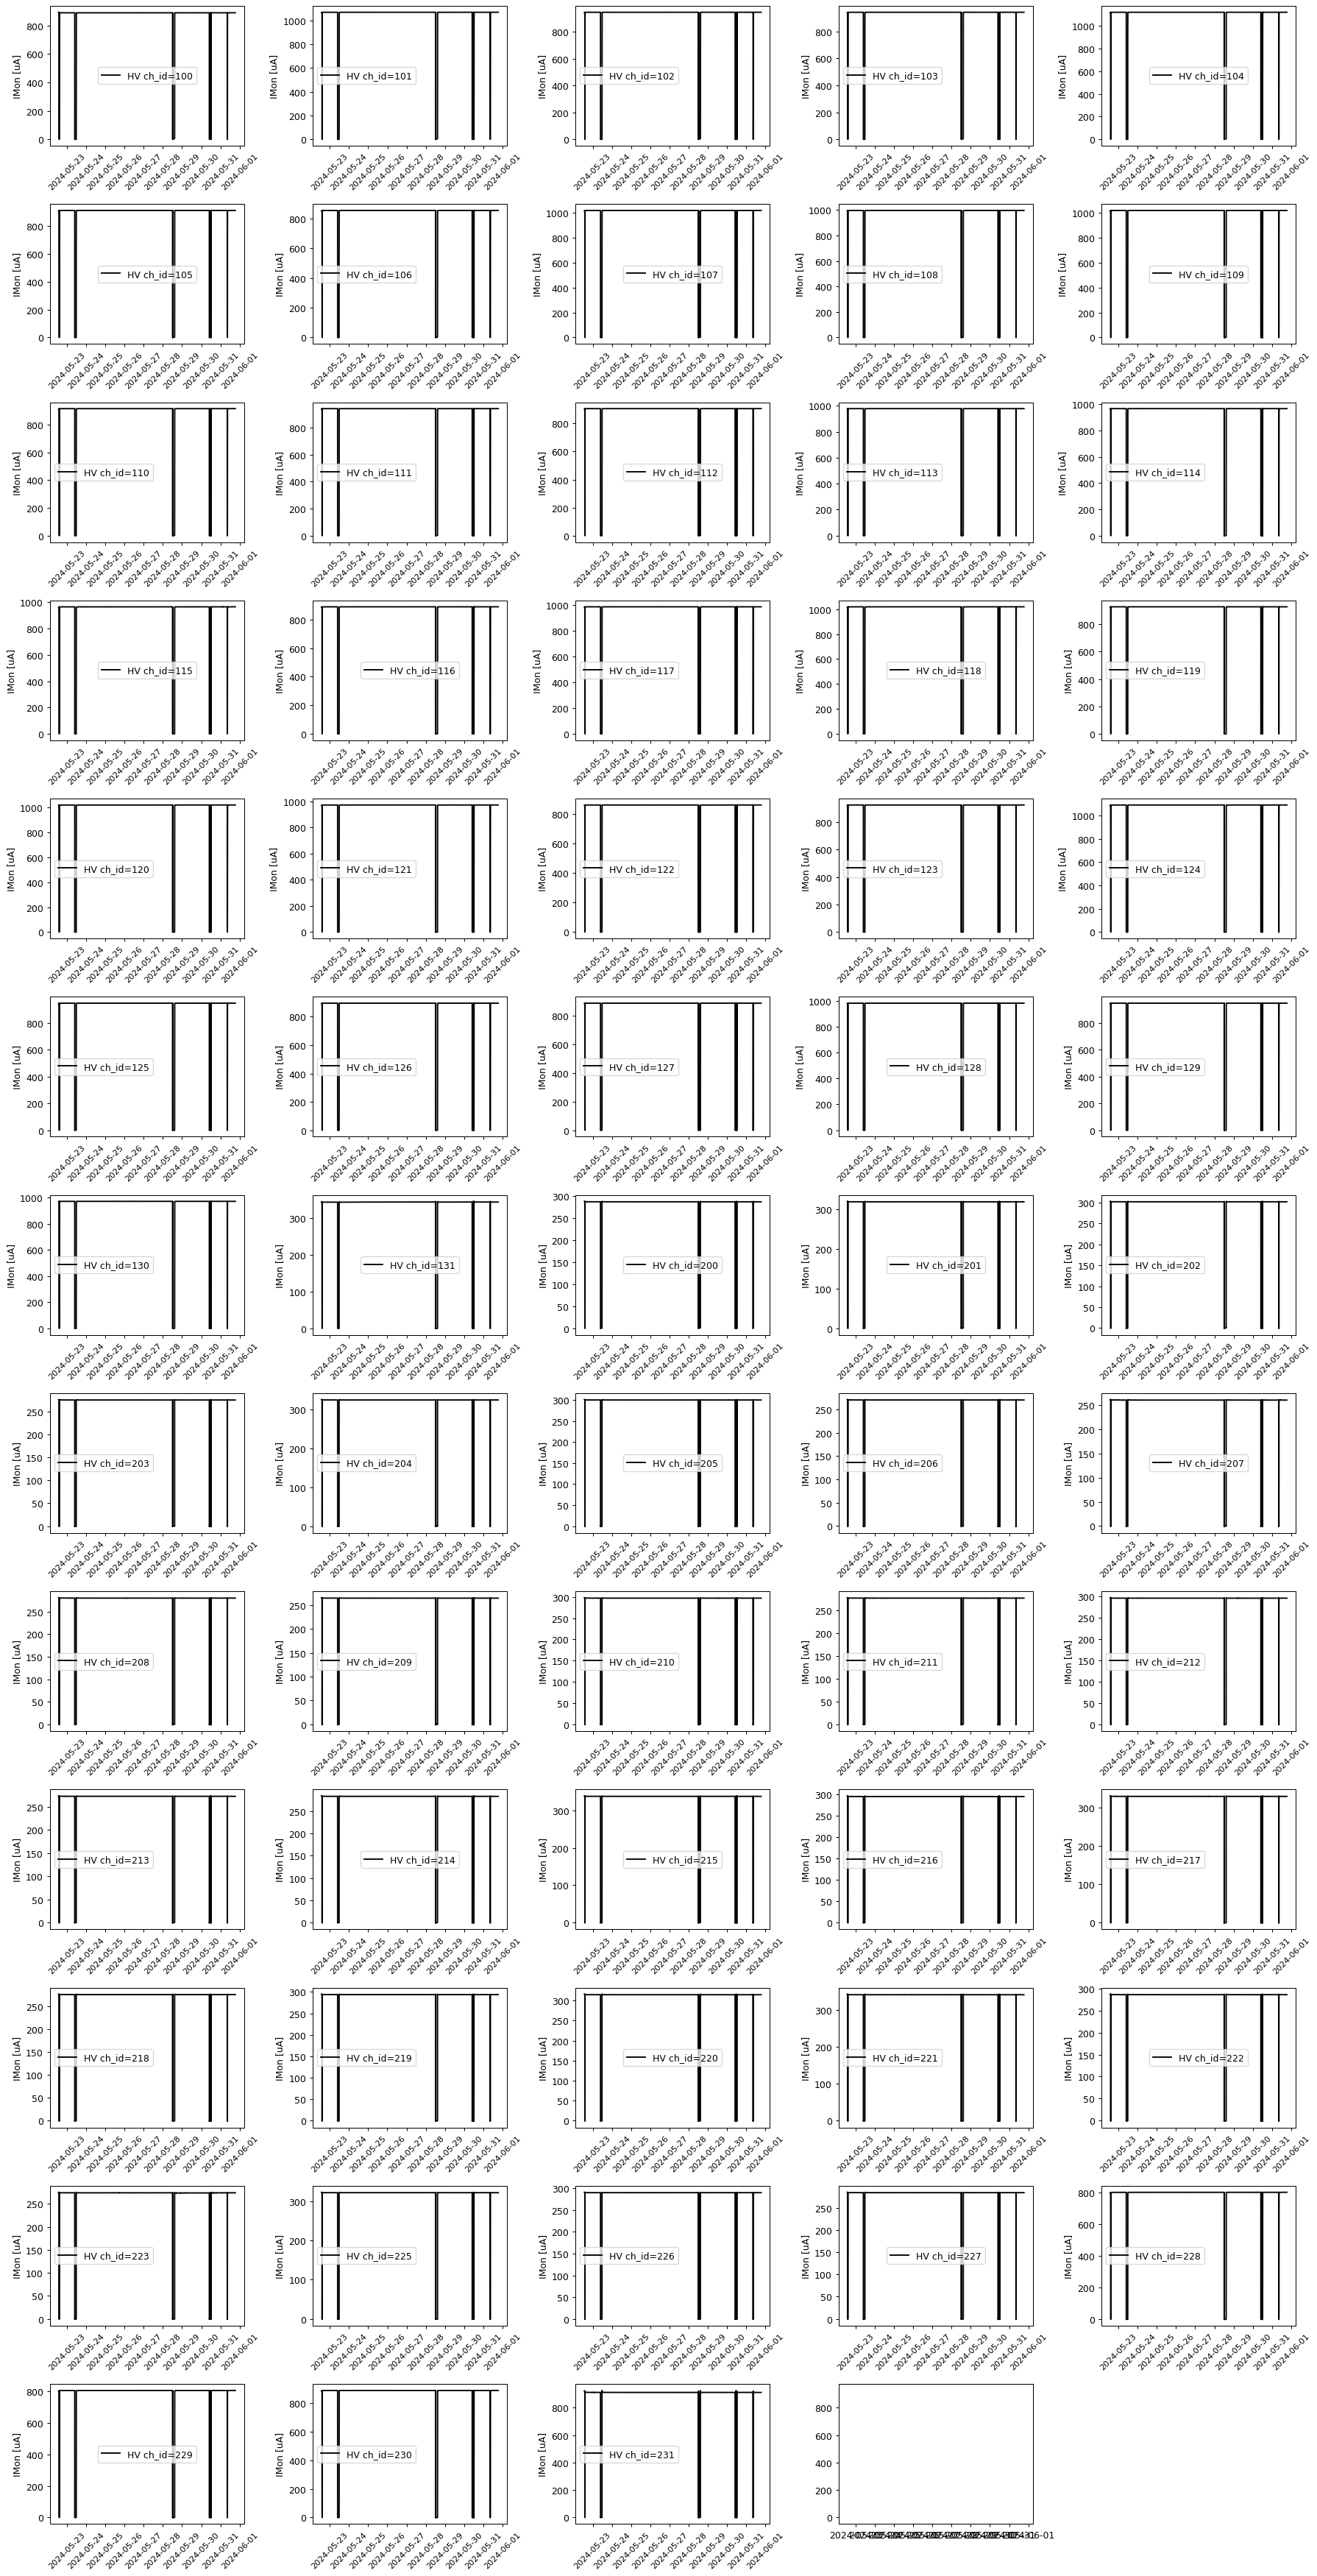

In [53]:
gp = GECOPlotter(file_path)

skipped_period=[
     ['600', '1000']
     ]

gp.plot_all_imon_trend(use_percentage=False, save_fig=True, fig_format='pdf')


Info: save fig to /home/wangbtc/VMon_IMon_230726T1508.pdf


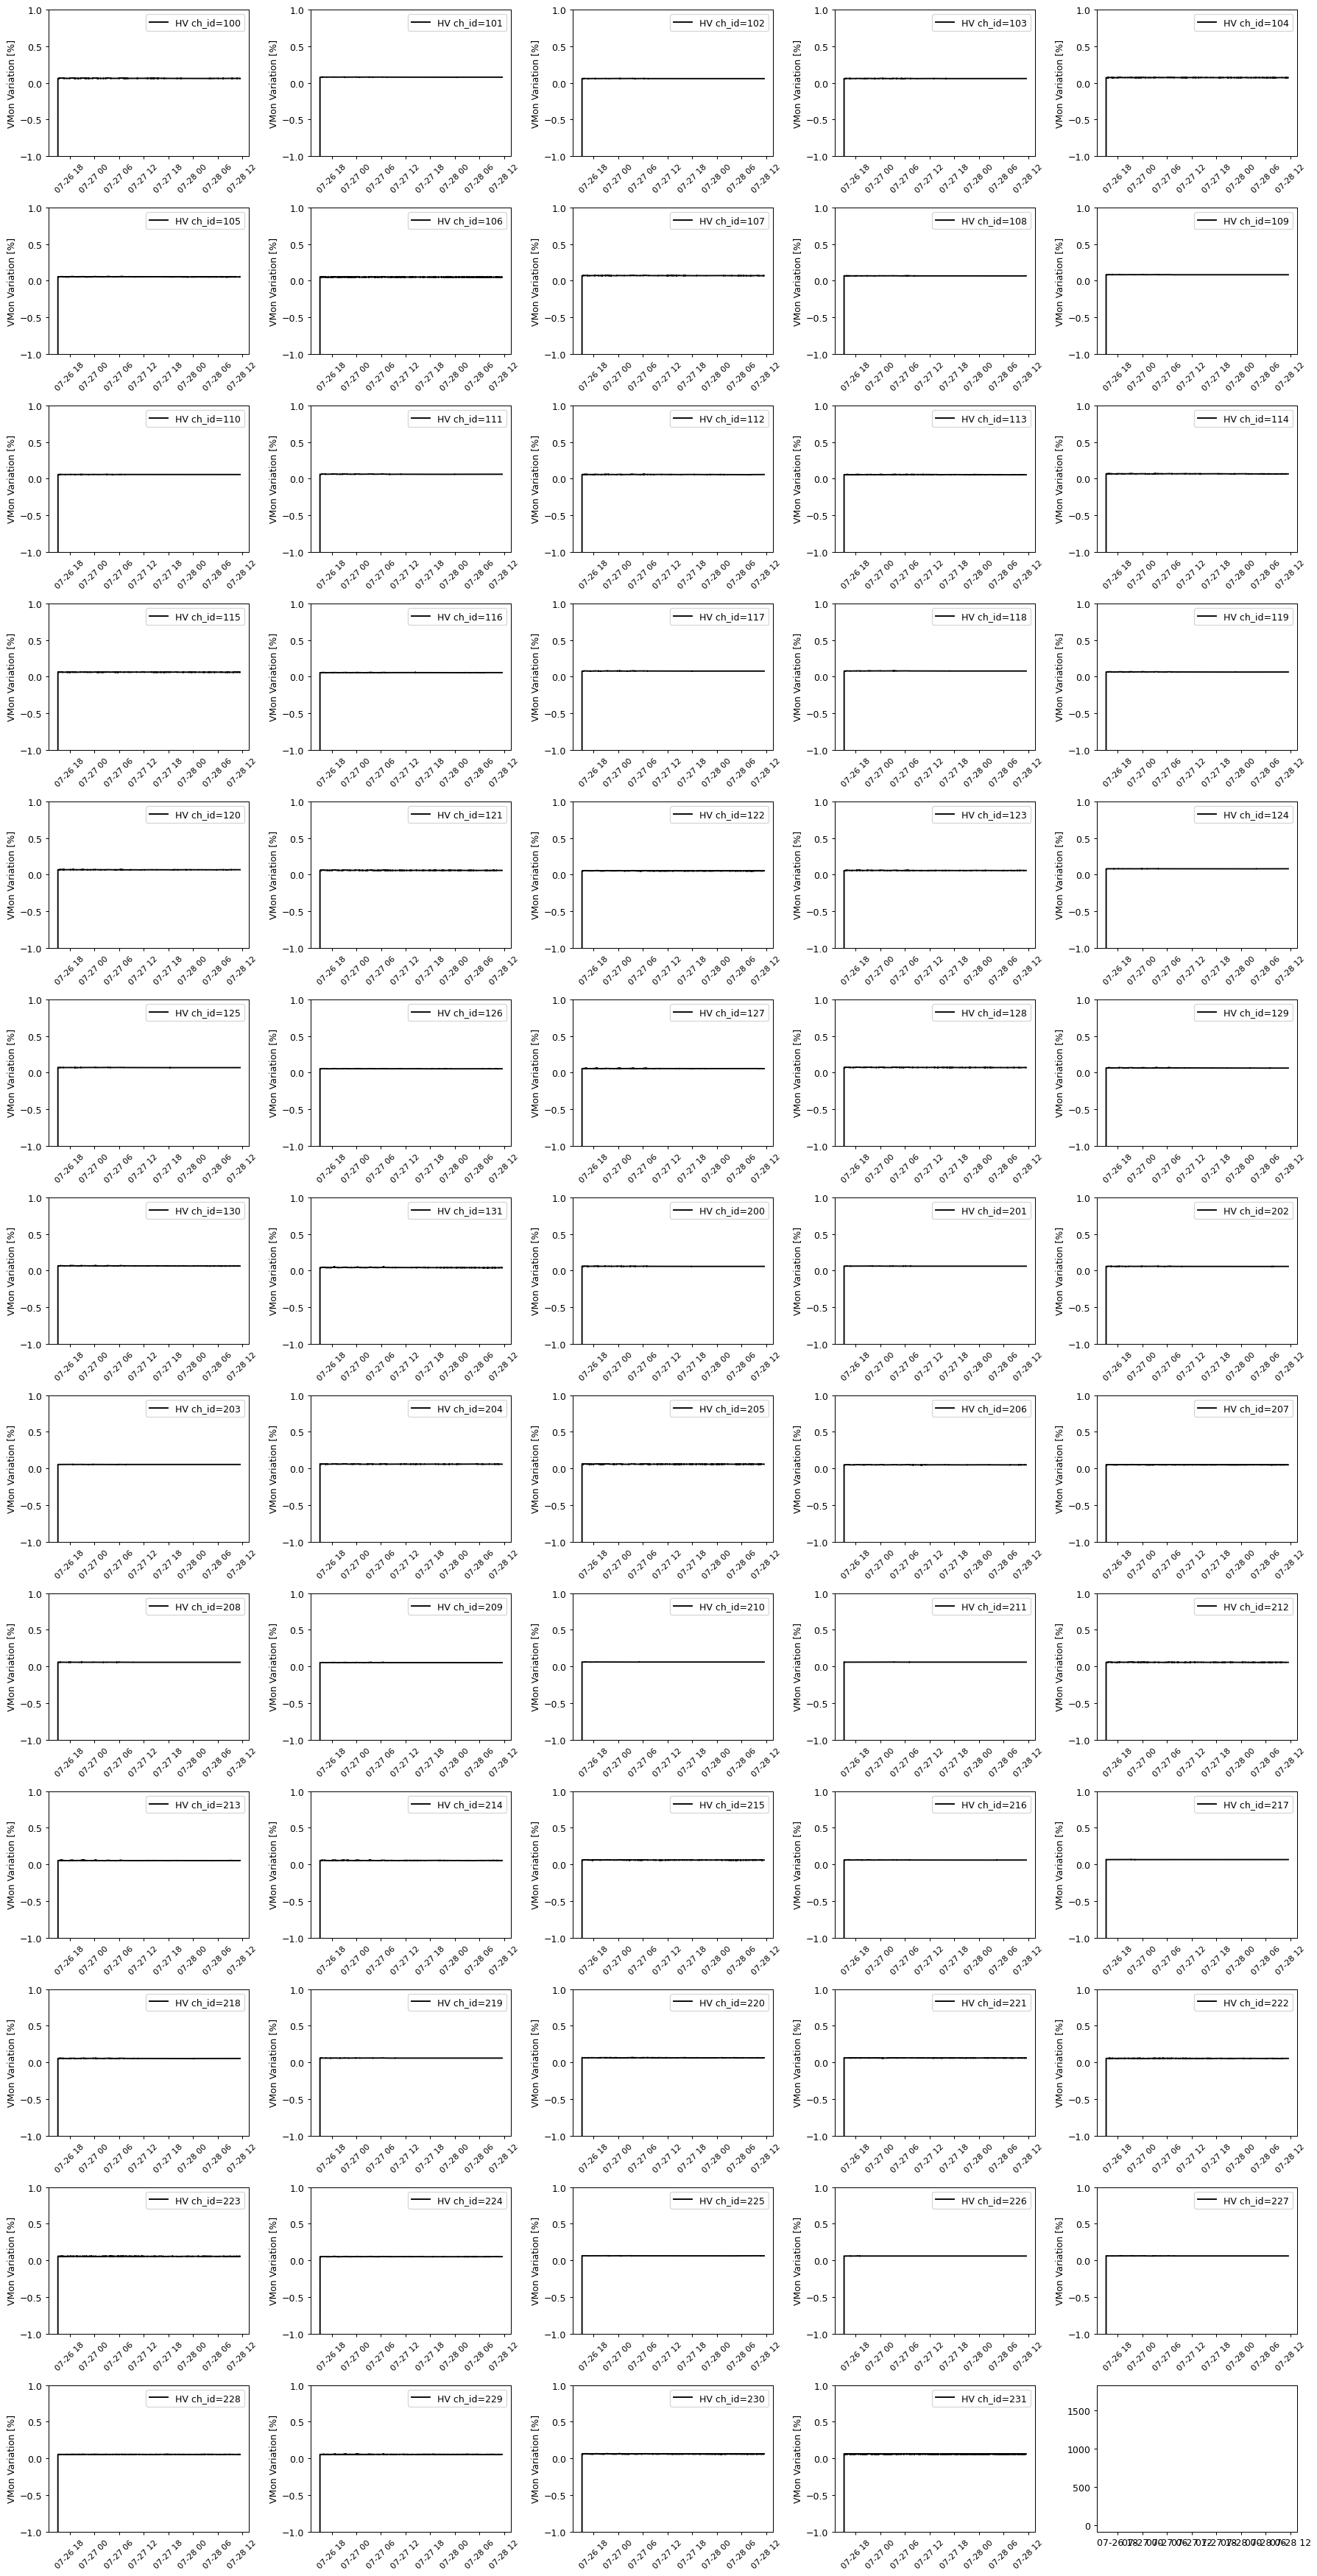

In [43]:
gp.plot_all_vmon_trend(use_percentage=True, save_fig=True, fig_format='pdf',y_range=(-1, 1))